In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [205]:

def get_meteo_weather_history(lat, lon, start_date, end_date):

    # API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "America/Los_Angeles"
    }

    # Make the request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    weather_df = pd.DataFrame({
        "date": data["daily"]["time"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "temp_min": data["daily"]["temperature_2m_min"],
        "precipitation": data["daily"]["precipitation_sum"]
    })

    # Convert date to datetime object
    weather_df["date"] = pd.to_datetime(weather_df["date"])


    return weather_df


Get the weather for Fort Mason Equator Coffe (don't do this over and over - this uses a free open source api which asks its users to respect the usage)
Save it to a CSV
Turns out we only need to do Fort Mason as the other two coffee shops are close by

In [206]:
# Date range (based on your dataset)
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fort Mason - Equator Coffee lat lon
fortMasonLatitude = 37.805424841127625
fortMasonLongitude = -122.43189815767089
# only run this if we lose our data and need to pull it again (uses a free api)
if (False):
    weather_df = get_meteo_weather_history(fortMasonLatitude, fortMasonLongitude, start_date, end_date)
    # Save to CSV
    weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv", index=False)
else:
    #weather_df = pd.read_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv")
    weatherURL = "https://www.dropbox.com/scl/fi/khb765ddg0qox6iy8qtkb/sanfran_weather.csv?rlkey=yccip6qd8kcx0jqz80jocddqf&dl=1"
    weather_data = pd.read_csv(weatherURL)


# Preview
print(weather_data.head())


# # Lake Merrit - Equator Coffee lat lon  - DON'T BOTHER - LAT LON IS NEARLY THE SAME AS FORT MASON
# lakeMerritLatitude = 37.81242756270673
# lakeMerritongitude = -122.26105919815194
# weather_df = get_meteo_weather_history(lakeMerritLatitude, lakeMerritongitude, start_date, end_date)
# # Save to CSV
# weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\lake_merrit_open_meteo_weather.csv", index=False)


         date  temp_max  temp_min  precipitation
0  2019-01-01      12.1       4.2            0.0
1  2019-01-02      11.6       4.5            0.0
2  2019-01-03      10.9       4.6            0.0
3  2019-01-04      12.0       4.9            0.0
4  2019-01-05      12.7       9.4            5.8


Clean the Data - Remove specific days like Christmas, New Years, etc.

In [207]:
# List of holidays to remove
holidays = [
    '2019-01-01', '2019-12-25', '2020-01-01', '2020-12-25', 
    '2021-01-01', '2021-12-25', '2022-01-01', '2022-12-25', 
    '2023-01-01', '2023-12-25', '2024-01-01', '2024-12-25'
]
# Convert holidays to datetime
holidays = pd.to_datetime(holidays)

# Remove holidays from weather data
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data[~weather_data['date'].isin(holidays)]

print("\nCleaned Weather Data:")
print(weather_data.head())


Cleaned Weather Data:
        date  temp_max  temp_min  precipitation
1 2019-01-02      11.6       4.5            0.0
2 2019-01-03      10.9       4.6            0.0
3 2019-01-04      12.0       4.9            0.0
4 2019-01-05      12.7       9.4            5.8
5 2019-01-06      13.4       8.5           36.5


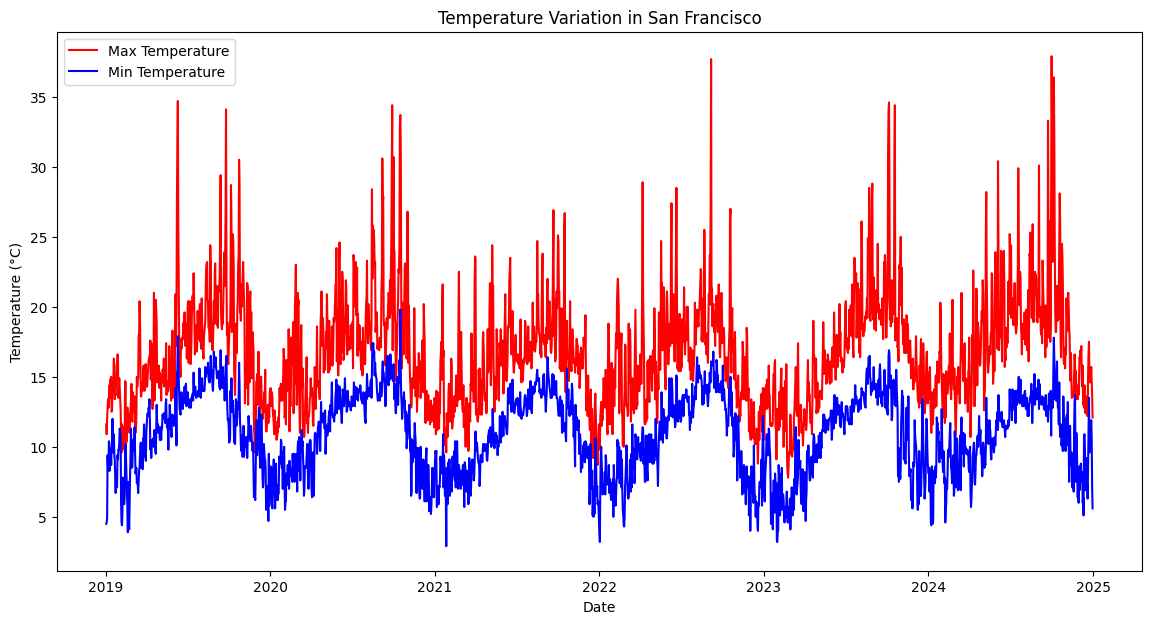

In [208]:
# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()
plt.show()


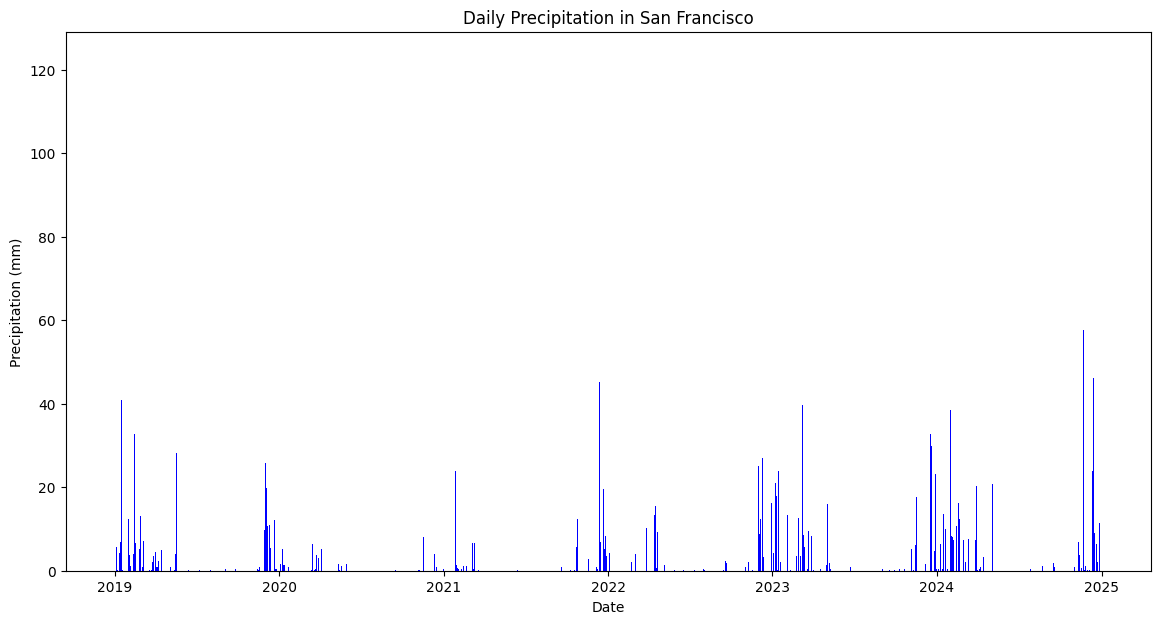

In [209]:
plt.figure(figsize=(14, 7))
plt.bar(weather_data['date'], weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco')
plt.show()

In [210]:
# Find the day with the highest precipitation
max_precipitation_day = weather_data.loc[weather_data['precipitation'].idxmax()]

print("Day with the highest precipitation:")
print(max_precipitation_day)

# How many days have precipitation greater than 50mm?
high_precipitation_days = weather_data[weather_data['precipitation'] > 50]
print("\nNumber of days with precipitation greater than 50mm:")
print(len(high_precipitation_days))


Day with the highest precipitation:
date             2022-12-31 00:00:00
temp_max                        13.2
temp_min                        10.5
precipitation                  123.0
Name: 1460, dtype: object

Number of days with precipitation greater than 50mm:
4


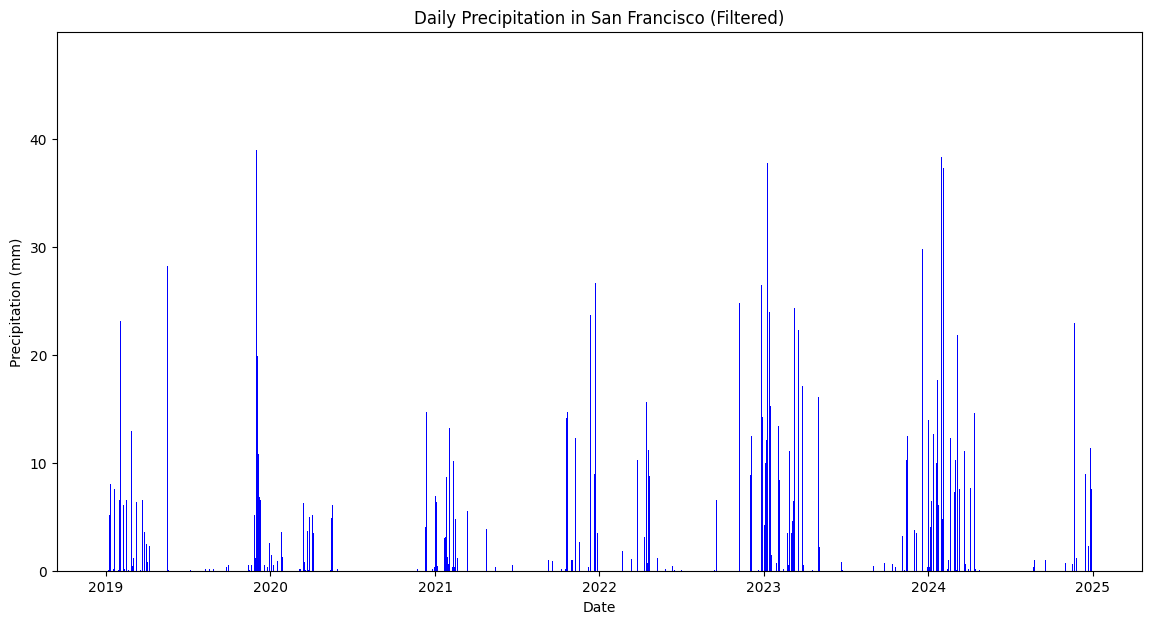

In [211]:
# Filter out days with precipitation greater than 50mm
filtered_weather_data = weather_data[weather_data['precipitation'] <= 50]

# Plot the daily precipitation
plt.figure(figsize=(14, 7))
plt.bar(filtered_weather_data['date'], filtered_weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco (Filtered)')
plt.show()

Next let's get our sales data for the 3 stores

Start with Fort Mason

In [212]:
fortMason5ySalesURL = "https://www.dropbox.com/scl/fi/c73v6ce9ij7rupc74quyz/FortMason5yrNetSalesbyDay.csv?rlkey=lnt0t56erqvea18fh052komur&dl=1"
fortMason5y_data = pd.read_csv(fortMason5ySalesURL)

# Preview
print(fortMason5y_data.head())



   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
1            6    Fort Mason  1/1/2019     Tuesday             FOOD   
2            6    Fort Mason  1/1/2019     Tuesday             FOOD   
3            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
4            6    Fort Mason  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1908.65        17.75             0  
1      Baked Goods-Pantry   199.75         0.00             0  
2  Retail Packaged-Pantry   178.00         0.00             0  
3         Other Beverages   163.50         0.00             0  
4           Retail Coffee   119.50         0.00             0  


Clean the Data

In [213]:
# Remove System Balance from the data
fortMason5y_data = fortMason5y_data[fortMason5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
fortMason5y_data = fortMason5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the fortMason5y_data
fortMason5y_data['DOB'] = pd.to_datetime(fortMason5y_data['DOB'])
fortMason5y_data = fortMason5y_data[~fortMason5y_data['DOB'].isin(holidays)]

# Preview
print(fortMason5y_data.head())


    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
12            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
13            6    Fort Mason 2019-01-02   Wednesday             FOOD   
14            6    Fort Mason 2019-01-02   Wednesday             FOOD   
15            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
16            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                           SD   AMOUNT  COMP AMOUNT  
12       Retail Coffee Drinks  1191.81        10.59  
13         Baked Goods-Pantry   209.00         0.00  
14  Retail Packaged-3rd party   196.26         2.24  
15                Accessories   196.00         5.00  
16              Retail Coffee   158.00         0.00  


SD
Accessories               123975.46
BLANK NAME                  4702.66
Baked Goods-3rd party    1166460.90
Baked Goods-Pantry         89699.68
Beer & Wine                23508.07
Brewing Equipment           4297.32
Catering                   35237.85
Donation                      30.00
Extra Items                   58.95
Ice Cream                   4348.45
Name: AMOUNT, dtype: float64
SD
Accessories                  1.239755e+05
BLANK NAME                   4.702660e+03
Baked Goods-3rd party        1.166461e+06
Baked Goods-Pantry           8.969968e+04
Beer & Wine                  2.350807e+04
Brewing Equipment            4.297320e+03
Catering                     3.523785e+04
Donation                     3.000000e+01
Extra Items                  5.895000e+01
Ice Cream                    4.348450e+03
Other Beverages              1.935497e+05
Prepared Foods               6.161446e+05
Retail Coffee                5.981950e+05
Retail Coffee Drinks         5.054600e+06
Retail Packaged-3

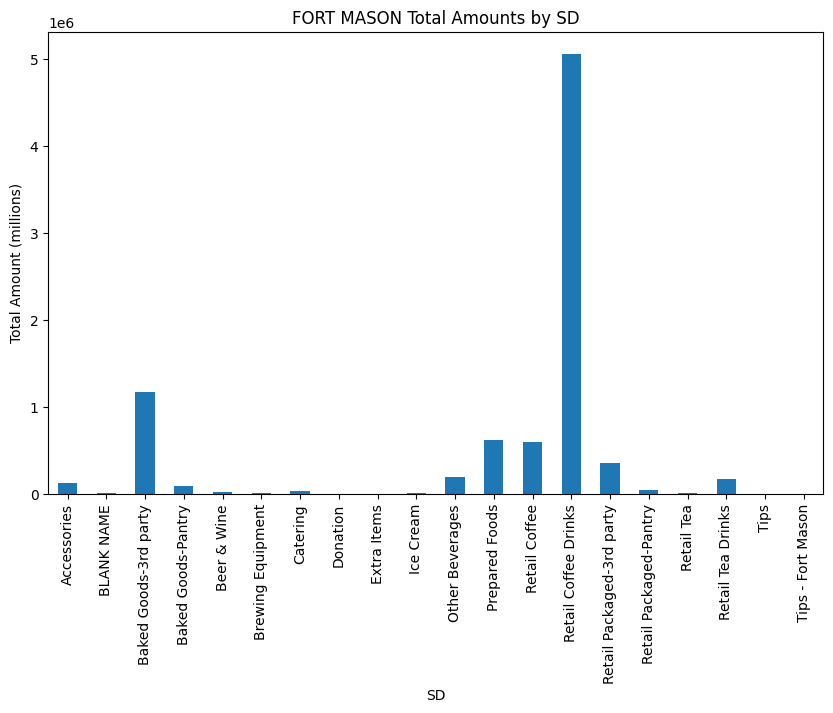

In [214]:

# Group the data by 'SD' and sum the 'AMOUNT'
fm_grouped_data = fortMason5y_data.groupby('SD')['AMOUNT'].sum()
print(fm_grouped_data.head(10))
print(fm_grouped_data)

# # Remove System Balance from the data
# fm_grouped_data = fm_grouped_data.drop('System Balance')

# Plot the data
plt.figure(figsize=(10, 6))
fm_grouped_data.plot(kind='bar')
plt.title('FORT MASON Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount (millions)')
plt.show()

In [215]:
blank_name_indices = fortMason5y_data[fortMason5y_data['SD'] == 'BLANK NAME'].index
print(blank_name_indices)

Index([ 4895,  4907,  4920,  4935,  4945,  4958,  4970,  4982,  4993,  5007,
        5030,  5038,  5052,  5390,  5398,  5405,  5410,  5435,  5440,  5448,
        5456,  5471,  5481,  5492,  5500,  5508,  5514,  6226,  6236,  6247,
        6254,  6264,  6553,  6631,  6669,  6680, 13514, 13721, 13911, 14025,
       14065, 14171, 15003, 15012, 15022, 15031, 15048, 15073, 15082, 15107,
       15117, 15128, 15496, 16007],
      dtype='int64')


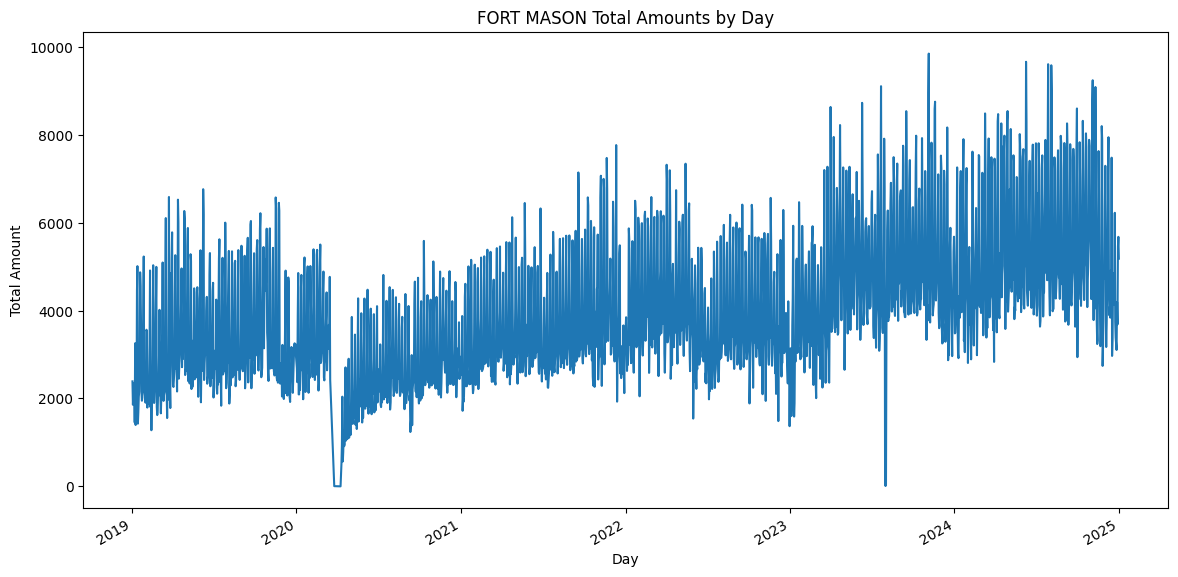

In [216]:
# Group the data by 'DOB' and sum the 'AMOUNT'
fm_daily_totals = fortMason5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
fm_daily_totals.plot(kind='line')
plt.title('FORT MASON Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()

In [217]:
# Find the days with zero sales (or very low sales) - see if they are Christmas, New Year's Day, etc. - but maybe it's too much rain or too hot!?
sales_anomolies_max = 250

unusually_low_sales_days = fm_daily_totals[fm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-25     4.25
2020-04-08     0.00
2023-07-31    40.00
2023-08-01     7.25
2023-08-02    42.00
Name: AMOUNT, dtype: float64


Now do Lake Merritt

In [218]:
lakeMerritt5ySalesURL = "https://www.dropbox.com/scl/fi/zcfrcc3mlhuapy2bqbyhc/LakeMerritt5yrNetSalesbyDay.csv?rlkey=7b0vk7k3frcwkoxg281tx4mpu&dl=1"
lakeMerritt5y_data = pd.read_csv(lakeMerritt5ySalesURL)

# Preview
print(lakeMerritt5y_data.head())


   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            7  Lake Merritt  1/1/2019     Tuesday  COFFEE & NA BEV   
1            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
2            7  Lake Merritt  1/1/2019     Tuesday           RETAIL   
3            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
4            7  Lake Merritt  1/1/2019     Tuesday             FOOD   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1141.88         0.22             0  
1      Baked Goods-Pantry   125.50         0.00             0  
2           Retail Coffee   108.00         0.00             0  
3          Prepared Foods    72.00         0.00             0  
4  Retail Packaged-Pantry    51.50         0.00             0  


Clean the data

In [219]:
# Remove System Balance from the data
lakeMerritt5y_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
lakeMerritt5y_data = lakeMerritt5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the data
lakeMerritt5y_data['DOB'] = pd.to_datetime(lakeMerritt5y_data['DOB'])
lakeMerritt5y_data = lakeMerritt5y_data[~lakeMerritt5y_data['DOB'].isin(holidays)]

# Preview
print(lakeMerritt5y_data.head())

    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
9             7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   
10            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
11            7  Lake Merritt 2019-01-02   Wednesday           RETAIL   
12            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
13            7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   

                        SD  AMOUNT  COMP AMOUNT  
9     Retail Coffee Drinks  602.68         2.52  
10      Baked Goods-Pantry  104.50         0.00  
11           Retail Coffee   47.45         0.00  
12  Retail Packaged-Pantry   44.00         0.00  
13       Retail Tea Drinks   21.00         0.00  


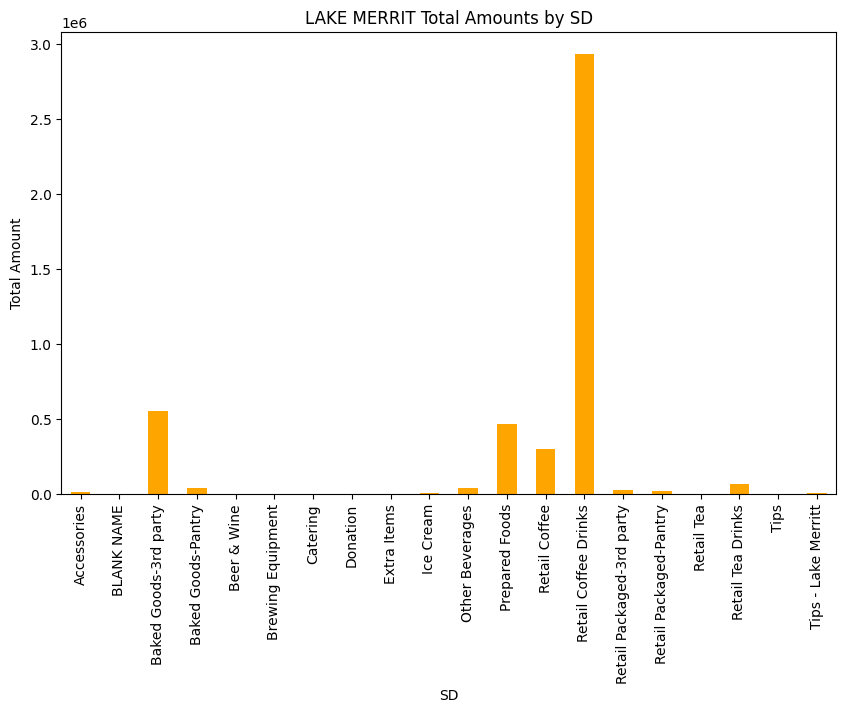

In [220]:
# Group the data by 'SD' and sum the 'AMOUNT'
lm_grouped_data = lakeMerritt5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
lm_grouped_data.plot(kind='bar', color='orange')
plt.title('LAKE MERRIT Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

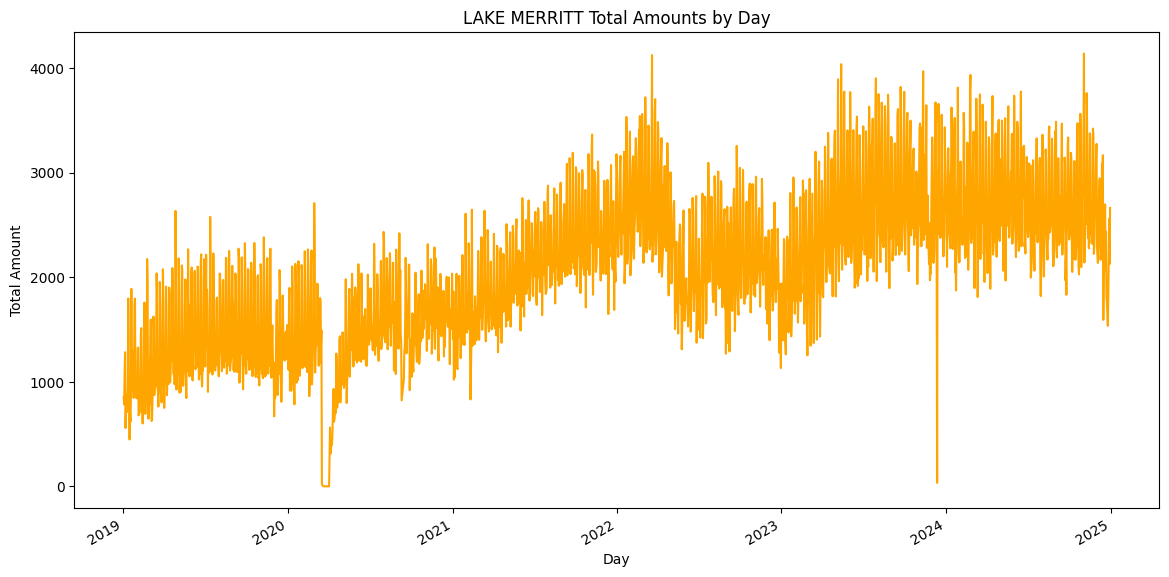

In [221]:
# Group the data by 'DOB' and sum the 'AMOUNT'
lm_daily_totals = lakeMerritt5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
lm_daily_totals.plot(kind='line', color='orange')
plt.title('LAKE MERRITT Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [222]:
unusually_low_sales_days = lm_daily_totals[lm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-17    20.5
2020-03-20     0.4
2020-04-02     0.0
2023-12-13    33.5
Name: AMOUNT, dtype: float64


Finally, do Larkspur

In [223]:
larkspur5ySalesURL = "https://www.dropbox.com/scl/fi/n037thzcegug919e0ajqj/Larkspur5yrNetSalesbyDay.csv?rlkey=3pg7sv4fbur1tfo2ax7ebz70z&dl=1"
larkspur5y_data = pd.read_csv(larkspur5ySalesURL)

# Preview
print(larkspur5y_data.head())

   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            4      Larkspur  1/1/2019     Tuesday  COFFEE & NA BEV   
1            4      Larkspur  1/1/2019     Tuesday             FOOD   
2            4      Larkspur  1/1/2019     Tuesday             FOOD   
3            4      Larkspur  1/1/2019     Tuesday             FOOD   
4            4      Larkspur  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1612.96        35.14             0  
1      Baked Goods-Pantry   185.00         0.00             0  
2   Baked Goods-3rd party   175.00         0.00             0  
3  Retail Packaged-Pantry   144.75         0.00             0  
4           Retail Coffee   142.50         0.00             0  


Clean the data

In [224]:
# Remove System Balance from the data
larkspur5y_data = larkspur5y_data[larkspur5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
larkspur5y_data = larkspur5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the data
larkspur5y_data['DOB'] = pd.to_datetime(larkspur5y_data['DOB'])
larkspur5y_data = larkspur5y_data[~larkspur5y_data['DOB'].isin(holidays)]

# Preview
print(larkspur5y_data.head())

    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
14            4      Larkspur 2019-01-02   Wednesday  COFFEE & NA BEV   
15            4      Larkspur 2019-01-02   Wednesday             FOOD   
16            4      Larkspur 2019-01-02   Wednesday             FOOD   
17            4      Larkspur 2019-01-02   Wednesday           RETAIL   
18            4      Larkspur 2019-01-02   Wednesday             FOOD   

                        SD   AMOUNT  COMP AMOUNT  
14    Retail Coffee Drinks  1285.48        23.47  
15      Baked Goods-Pantry   203.00         0.00  
16   Baked Goods-3rd party   166.75         0.00  
17           Retail Coffee   158.03         5.47  
18  Retail Packaged-Pantry   156.00         0.00  


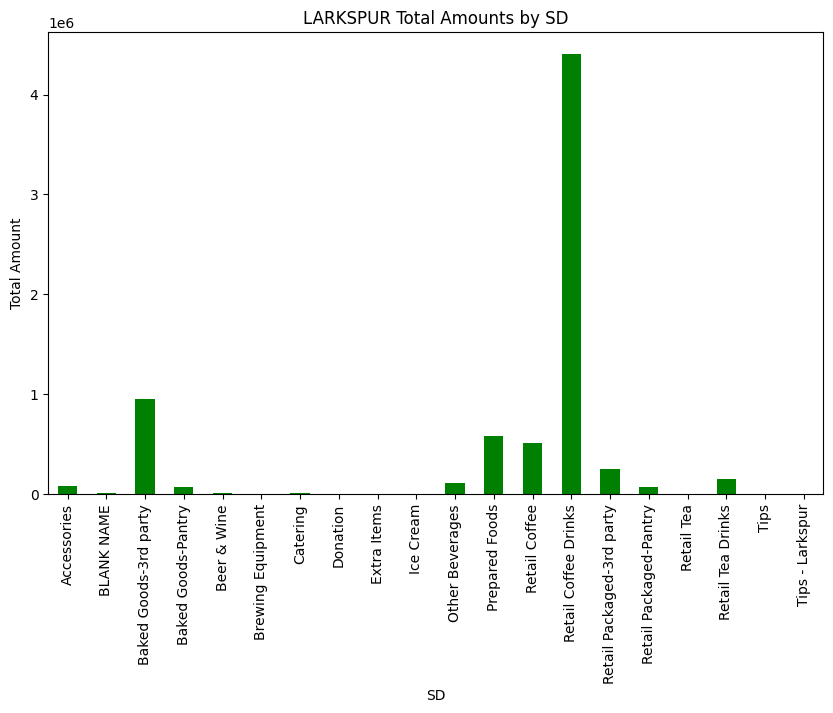

In [225]:
# Group the data by 'SD' and sum the 'AMOUNT'
ls_grouped_data = larkspur5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
ls_grouped_data.plot(kind='bar', color='green')
plt.title('LARKSPUR Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

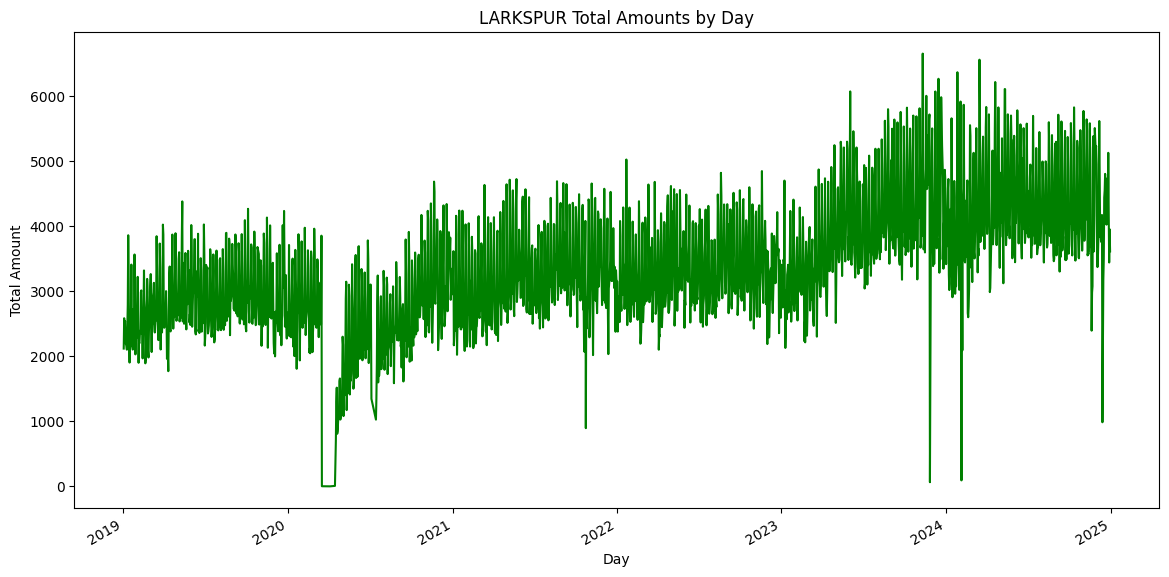

In [226]:
# Convert 'DOB' to datetime
larkspur5y_data['DOB'] = pd.to_datetime(larkspur5y_data['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
ls_daily_totals = larkspur5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
ls_daily_totals.plot(kind='line', color='green')
plt.title('LARKSPUR Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [227]:
unusually_low_sales_days = ls_daily_totals[ls_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-17     4.00
2020-04-04     2.50
2020-04-15     9.25
2023-11-27    66.00
2024-02-05    94.00
Name: AMOUNT, dtype: float64


Merge the sales date for all 3 stores into one graph

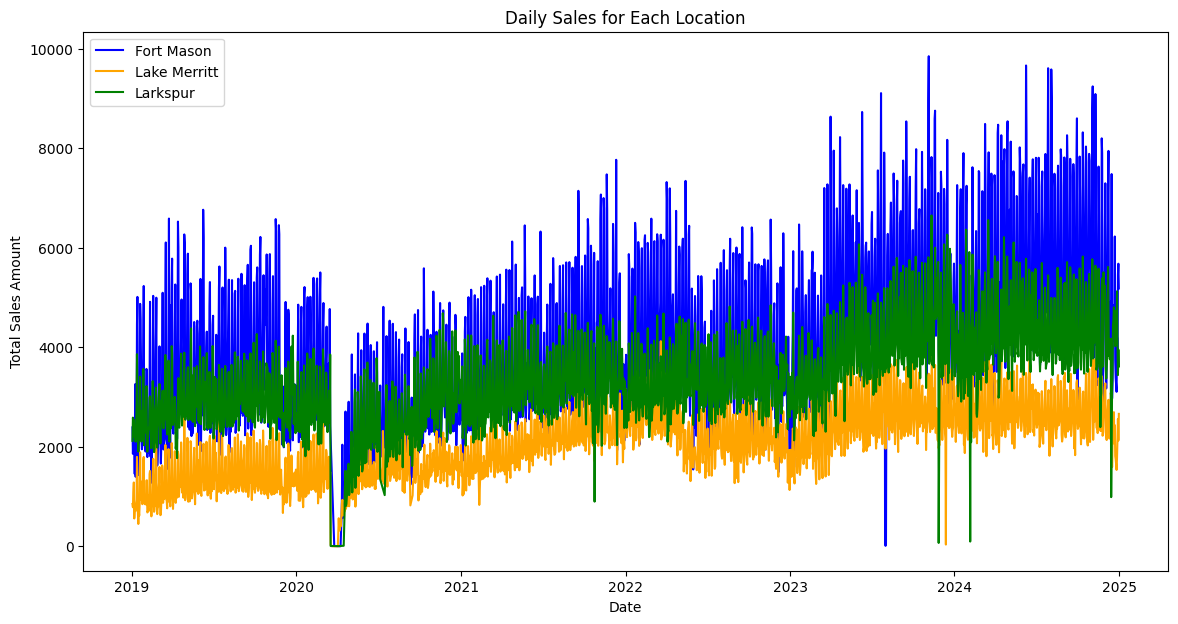

In [228]:
# Plot the daily sales for each location in one graph
plt.figure(figsize=(14, 7))

# Plot Fort Mason daily sales
plt.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason', color='blue')

# Plot Lake Merritt daily sales
plt.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt', color='orange')

# Plot Larkspur daily sales
plt.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Daily Sales for Each Location')
plt.legend()

# Show the plot
plt.show()

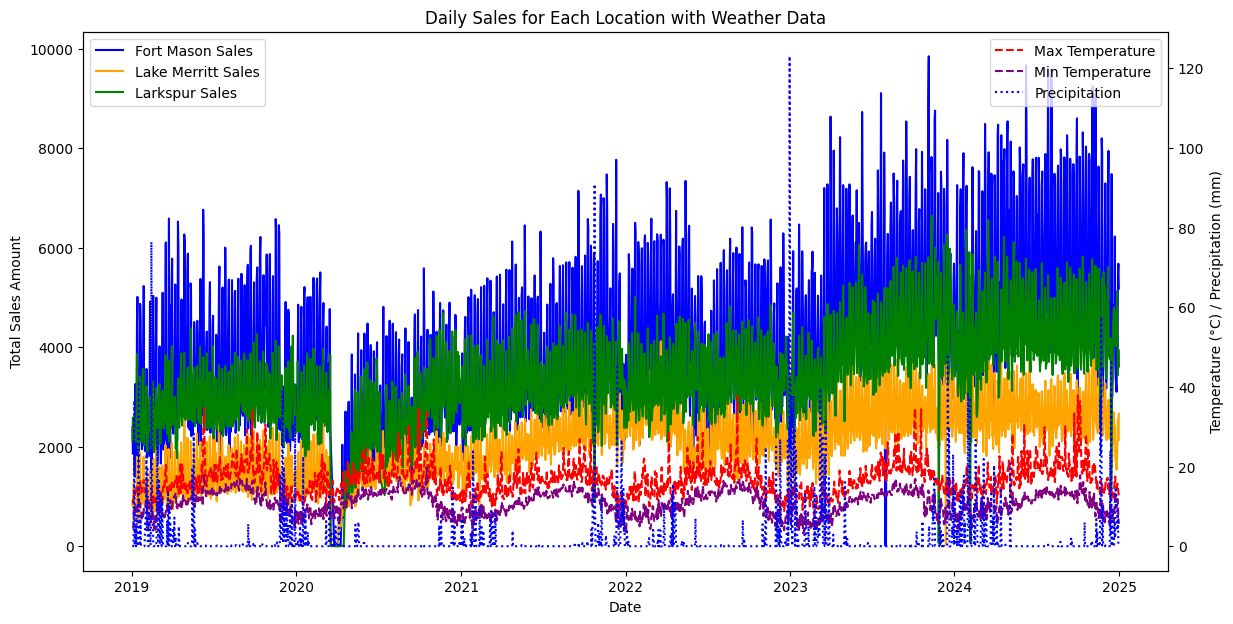

In [229]:
# Plot the daily sales for each location in one graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Fort Mason daily sales
ax1.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason Sales', color='blue')

# Plot Lake Merritt daily sales
ax1.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt Sales', color='orange')

# Plot Larkspur daily sales
ax1.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur Sales', color='green')

# Add labels and title for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount')
ax1.set_title('Daily Sales for Each Location with Weather Data')
ax1.legend(loc='upper left')

# Create a secondary y-axis for weather data
ax2 = ax1.twinx()

# Plot Max Temperature
ax2.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red', linestyle='--')

# Plot Min Temperature
ax2.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='purple', linestyle='--')

# Plot Precipitation
ax2.plot(weather_data['date'], weather_data['precipitation'], label='Precipitation', color='blue', linestyle=':')

# Add labels for weather data
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [230]:
# Combine sales data from all stores
combined_sales_data = pd.DataFrame({
    'date': fm_daily_totals.index,
    'Fort Mason Sales': fm_daily_totals.values,
    'Lake Merritt Sales': lm_daily_totals.reindex(fm_daily_totals.index, fill_value=0).values,
    'Larkspur Sales': ls_daily_totals.reindex(fm_daily_totals.index, fill_value=0).values
})

# Merge with weather data
combined_data = pd.merge(combined_sales_data, weather_data, on='date')

# Define features and target variables
X = combined_data[['temp_max', 'temp_min', 'precipitation']]
y_fort_mason = combined_data['Fort Mason Sales']
y_lake_merritt = combined_data['Lake Merritt Sales']
y_larkspur = combined_data['Larkspur Sales']

# Create and fit the model for Fort Mason
model_fort_mason = LinearRegression()
model_fort_mason.fit(X, y_fort_mason)

# Create and fit the model for Lake Merritt
model_lake_merritt = LinearRegression()
model_lake_merritt.fit(X, y_lake_merritt)

# Create and fit the model for Larkspur
model_larkspur = LinearRegression()
model_larkspur.fit(X, y_larkspur)

# Print the coefficients
print("Fort Mason Model Coefficients:", model_fort_mason.coef_)
print("Lake Merritt Model Coefficients:", model_lake_merritt.coef_)
print("Larkspur Model Coefficients:", model_larkspur.coef_)

# Print the intercepts
print("Fort Mason Model Intercept:", model_fort_mason.intercept_)
print("Lake Merritt Model Intercept:", model_lake_merritt.intercept_)
print("Larkspur Model Intercept:", model_larkspur.intercept_)

Fort Mason Model Coefficients: [ 82.30269097 -76.52224539 -23.43608231]
Lake Merritt Model Coefficients: [ 27.3822995  -27.00726506  -6.77518541]
Larkspur Model Coefficients: [ 37.64420492 -36.83576336 -13.74251142]
Fort Mason Model Intercept: 3439.2583320681456
Lake Merritt Model Intercept: 1922.5020867286412
Larkspur Model Intercept: 3141.510240321425


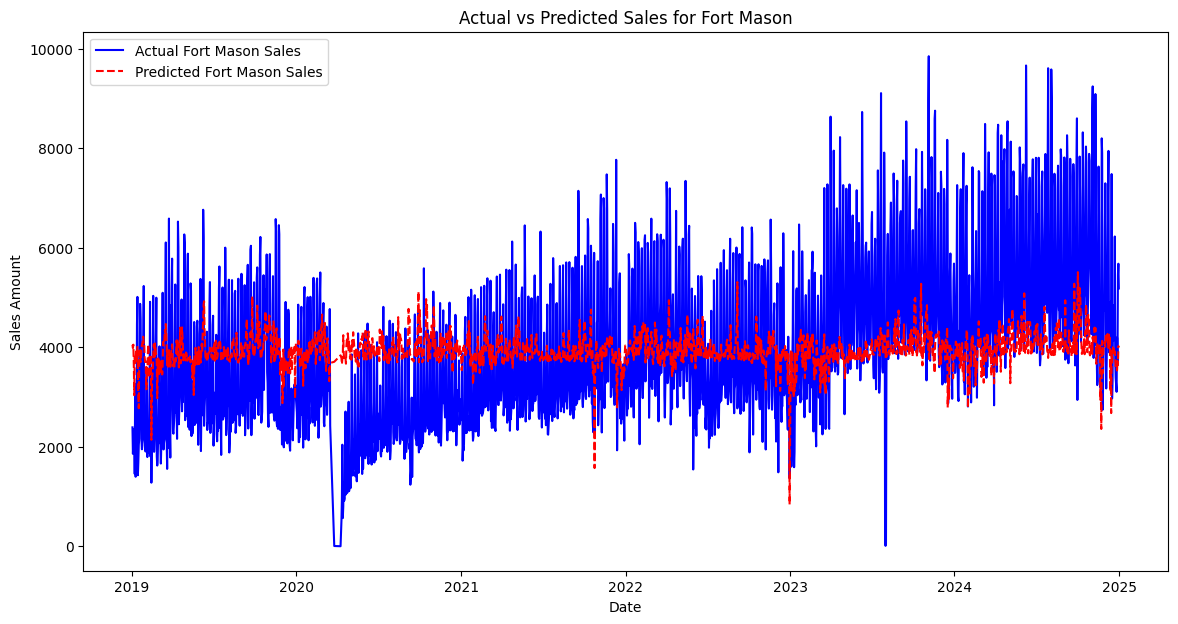

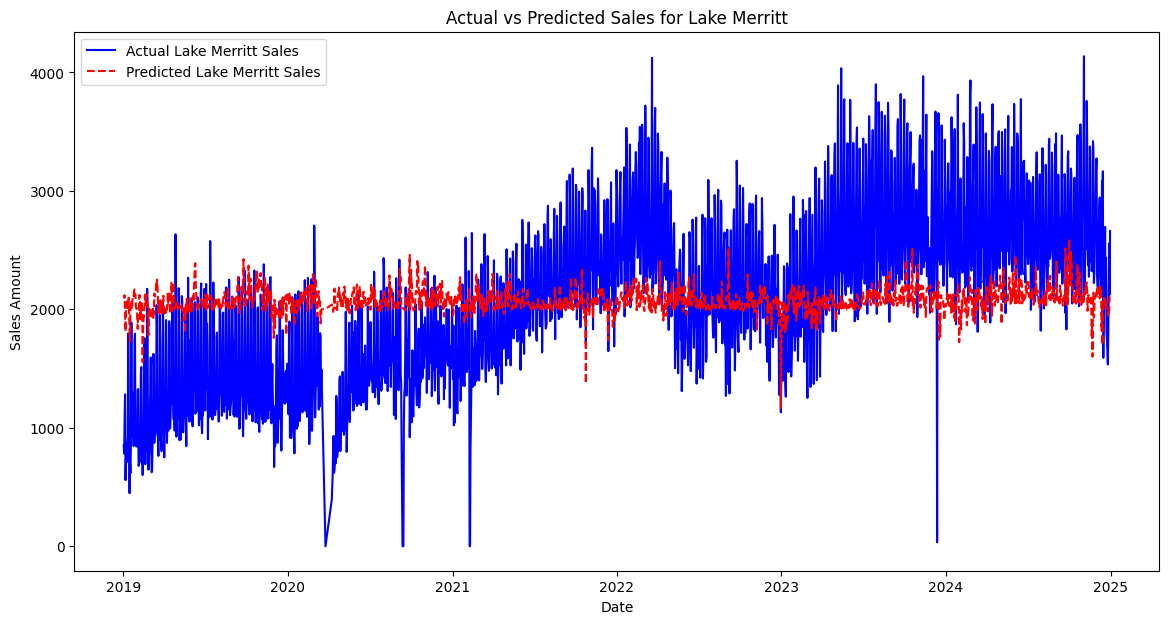

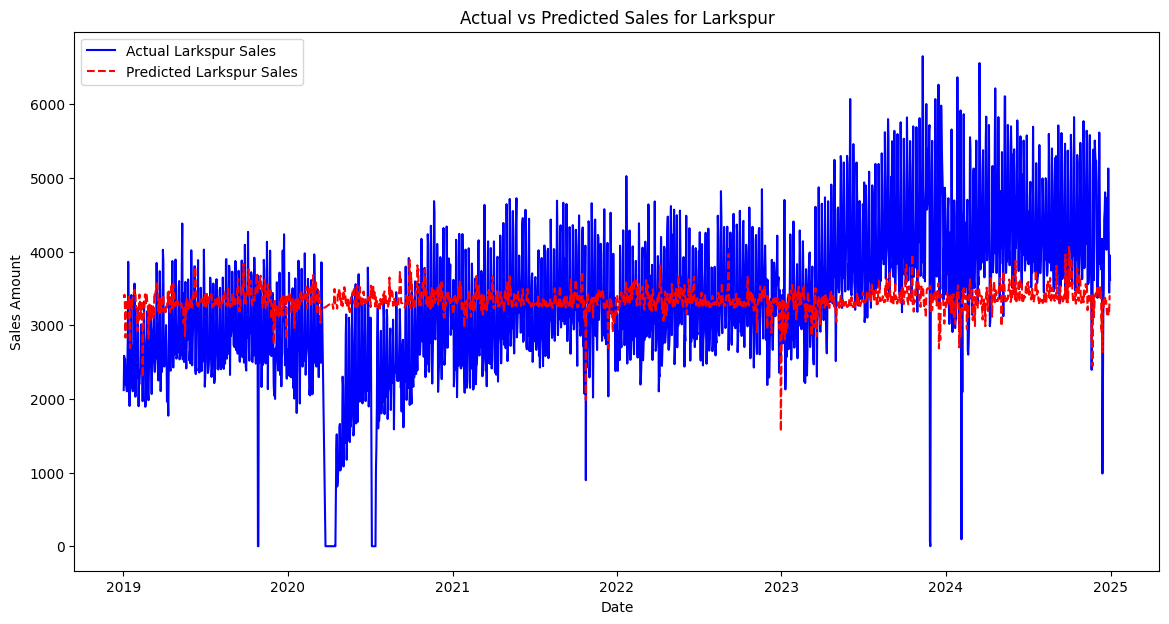

In [231]:
# Predict sales using the linear regression models
pred_fort_mason = model_fort_mason.predict(X)
pred_lake_merritt = model_lake_merritt.predict(X)
pred_larkspur = model_larkspur.predict(X)

# Plot the actual vs predicted sales for Fort Mason
plt.figure(figsize=(14, 7))
plt.plot(combined_data['date'], y_fort_mason, label='Actual Fort Mason Sales', color='blue')
plt.plot(combined_data['date'], pred_fort_mason, label='Predicted Fort Mason Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Actual vs Predicted Sales for Fort Mason')
plt.legend()
plt.show()

# Plot the actual vs predicted sales for Lake Merritt
plt.figure(figsize=(14, 7))
plt.plot(combined_data['date'], y_lake_merritt, label='Actual Lake Merritt Sales', color='blue')
plt.plot(combined_data['date'], pred_lake_merritt, label='Predicted Lake Merritt Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Actual vs Predicted Sales for Lake Merritt')
plt.legend()
plt.show()

# Plot the actual vs predicted sales for Larkspur
plt.figure(figsize=(14, 7))
plt.plot(combined_data['date'], y_larkspur, label='Actual Larkspur Sales', color='blue')
plt.plot(combined_data['date'], pred_larkspur, label='Predicted Larkspur Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Actual vs Predicted Sales for Larkspur')
plt.legend()
plt.show()

In [232]:
# Define the ElasticNet model
elastic_net_model = ElasticNet()

# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model for Fort Mason
grid_search.fit(X, y_fort_mason)
best_model_fort_mason = grid_search.best_estimator_

# Fit the model for Lake Merritt
grid_search.fit(X, y_lake_merritt)
best_model_lake_merritt = grid_search.best_estimator_

# Fit the model for Larkspur
grid_search.fit(X, y_larkspur)
best_model_larkspur = grid_search.best_estimator_

# Print the best parameters
print("Best parameters for Fort Mason:", grid_search.best_params_)
print("Best parameters for Lake Merritt:", grid_search.best_params_)
print("Best parameters for Larkspur:", grid_search.best_params_)

# Predict sales using the best models
pred_fort_mason_en = best_model_fort_mason.predict(X)
pred_lake_merritt_en = best_model_lake_merritt.predict(X)
pred_larkspur_en = best_model_larkspur.predict(X)

# Identify unusually low sales days
unusually_low_sales_fort_mason = combined_data[y_fort_mason < sales_anomolies_max]
unusually_low_sales_lake_merritt = combined_data[y_lake_merritt < sales_anomolies_max]
unusually_low_sales_larkspur = combined_data[y_larkspur < sales_anomolies_max]

# Print the unusually low sales days with weather data
print("Unusually low sales days for Fort Mason:")
print(unusually_low_sales_fort_mason[['date', 'Fort Mason Sales', 'temp_max', 'temp_min', 'precipitation']])

print("\nUnusually low sales days for Lake Merritt:")
print(unusually_low_sales_lake_merritt[['date', 'Lake Merritt Sales', 'temp_max', 'temp_min', 'precipitation']])

print("\nUnusually low sales days for Larkspur:")
print(unusually_low_sales_larkspur[['date', 'Larkspur Sales', 'temp_max', 'temp_min', 'precipitation']])

Best parameters for Fort Mason: {'alpha': 10.0, 'l1_ratio': 0.1}
Best parameters for Lake Merritt: {'alpha': 10.0, 'l1_ratio': 0.1}
Best parameters for Larkspur: {'alpha': 10.0, 'l1_ratio': 0.1}
Unusually low sales days for Fort Mason:
           date  Fort Mason Sales  temp_max  temp_min  precipitation
438  2020-03-25              4.25      11.0       7.7            2.0
439  2020-04-08              0.00      13.4       9.2            0.0
1638 2023-07-31             40.00      20.8      12.9            0.0
1639 2023-08-01              7.25      16.7      13.2            0.0
1640 2023-08-02             42.00      18.6      13.4            0.0

Unusually low sales days for Lake Merritt:
           date  Lake Merritt Sales  temp_max  temp_min  precipitation
438  2020-03-25                 0.0      11.0       7.7            2.0
594  2020-09-12                 0.0      17.5      13.8            0.0
595  2020-09-13                 0.0      15.8      12.9            0.0
596  2020-09-14       

In [233]:
# Extract sales data for specific items
items_of_interest = ['Baked Goods-Pantry', 'Retail Packaged-Pantry', 'Ice Cream', 'Retail Coffee Drinks']

# Filter the sales data for Fort Mason
fort_mason_items_data = fortMason5y_data[fortMason5y_data['SD'].isin(items_of_interest)]
fort_mason_items_grouped = fort_mason_items_data.groupby(['DOB', 'SD'])['AMOUNT'].sum().unstack().fillna(0)

# Filter the sales data for Lake Merritt
lake_merritt_items_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'].isin(items_of_interest)]
lake_merritt_items_grouped = lake_merritt_items_data.groupby(['DOB', 'SD'])['AMOUNT'].sum().unstack().fillna(0)

# Filter the sales data for Larkspur
larkspur_items_data = larkspur5y_data[larkspur5y_data['SD'].isin(items_of_interest)]
larkspur_items_grouped = larkspur_items_data.groupby(['DOB', 'SD'])['AMOUNT'].sum().unstack().fillna(0)

# Merge with weather data
fort_mason_combined = pd.merge(fort_mason_items_grouped, weather_data, left_index=True, right_on='date')
lake_merritt_combined = pd.merge(lake_merritt_items_grouped, weather_data, left_index=True, right_on='date')
larkspur_combined = pd.merge(larkspur_items_grouped, weather_data, left_index=True, right_on='date')

# Define features and target variables
X_fort_mason = fort_mason_combined[['temp_max', 'temp_min', 'precipitation']]
y_fort_mason = fort_mason_combined[items_of_interest]

X_lake_merritt = lake_merritt_combined[['temp_max', 'temp_min', 'precipitation']]
y_lake_merritt = lake_merritt_combined[items_of_interest]

X_larkspur = larkspur_combined[['temp_max', 'temp_min', 'precipitation']]
y_larkspur = larkspur_combined[items_of_interest]

# Create and fit the models using ElasticNet
best_models = {}
for item in items_of_interest:
    # Fort Mason
    grid_search.fit(X_fort_mason, y_fort_mason[item])
    best_models[f'Fort Mason {item}'] = grid_search.best_estimator_

    # Lake Merritt
    grid_search.fit(X_lake_merritt, y_lake_merritt[item])
    best_models[f'Lake Merritt {item}'] = grid_search.best_estimator_

    # Larkspur
    grid_search.fit(X_larkspur, y_larkspur[item])
    best_models[f'Larkspur {item}'] = grid_search.best_estimator_

# Print the best parameters and coefficients for each model
for key, model in best_models.items():
    print(f"Best parameters for {key}: {model.get_params()}")
    print(f"Coefficients for {key}: {model.coef_}")
    print(f"Intercept for {key}: {model.intercept_}\n")

Best parameters for Fort Mason Baked Goods-Pantry: {'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Coefficients for Fort Mason Baked Goods-Pantry: [-0.         1.2532648  0.       ]
Intercept for Fort Mason Baked Goods-Pantry: 28.00237755258192

Best parameters for Lake Merritt Baked Goods-Pantry: {'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Coefficients for Lake Merritt Baked Goods-Pantry: [-0.          0.33734939 -0.        ]
Intercept for Lake Merritt Baked Goods-Pantry: 14.725449584007569

Best parameters for Larkspur Baked Goods-Pantry: {'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': 